# Single sample quality control with Seurat
**Authorship:** Adam Klie (last updated: 10/02/2023)<br>
***
**Description:**
Adapted from Mei's notebook for doing this

# Set-up

In [1]:
# Make sure reticulate is installed in R
Sys.setenv(RETICULATE_PYTHON="/cellar/users/aklie/opt/miniconda3/envs/scverse-R433/bin/python")
suppressMessages(library(reticulate))
suppressMessages(library(GenomeInfoDb))

In [2]:
# Make sure the python environment is set up correctly
reticulate::use_python("/cellar/users/aklie/opt/miniconda3/envs/scverse-R433/bin/python")
reticulate::use_condaenv("/cellar/users/aklie/opt/miniconda3/envs/scverse-R433")
reticulate::py_module_available(module='leidenalg')  # needs to be TRUE
reticulate::import('leidenalg')  # good to make sure this doesn't error

[1] TRUE

Module(leidenalg)

In [3]:
# Load libraries
suppressMessages(library(hdf5r))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(EnsDb.Hsapiens.v86))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(Matrix))
suppressMessages(library(harmony))
suppressMessages(library(data.table))
suppressMessages(library(ggpubr))
warnLevel <- getOption('warn')
options(warn = -1)

# Read in data

In [4]:
# Read in single sample cellranger output
sample <- 'DM32A'

wd <- sprintf('/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/processed/21Jul23/igvf_dm32a_deep')
inputdata.10x <- Read10X_h5(file.path(wd, 'outs', 'raw_feature_bc_matrix.h5'))
rna_counts <- inputdata.10x$`Gene Expression`
atac_counts <- inputdata.10x$`Peaks`
adata <- CreateSeuratObject(counts=rna_counts)
adata[['percent.mt']] <- PercentageFeatureSet(adata, pattern = '^MT-')
print(paste(length(colnames(adata[["RNA"]])),"total BCs"))
adata

Genome matrix has multiple modalities, returning a list of matrices for this genome



[1] "652051 total BCs"


An object of class Seurat 
36601 features across 652051 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

# Filter by RNA and ATAC Metrics

### Remove doublets (AMULET)

In [5]:
# Read in the amulet multiplets as a list
amulet_multiplets <- read.table(file.path(wd, 'MultipletBarcodes_01.txt'))
length(amulet_multiplets)

[1] 1

In [6]:
# Remove any multiplets from the data
adata_sub_amulet <- adata[,!(colnames(adata) %in% amulet_multiplets$V1)]
adata_sub_amulet

An object of class Seurat 
36601 features across 651392 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

### Visualize distribution of # genes detected/barcode

In [7]:
# Remove empty barcodes/almost-empty barcodes
adata_nonzero <- subset(
  x = adata,
  subset = nFeature_RNA > 100
)
print(paste(length(colnames(adata_nonzero[["RNA"]])),"total BCs after RNA threshold"))
adata_nonzero

[1] "11400 total BCs after RNA threshold"


An object of class Seurat 
36601 features across 11400 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

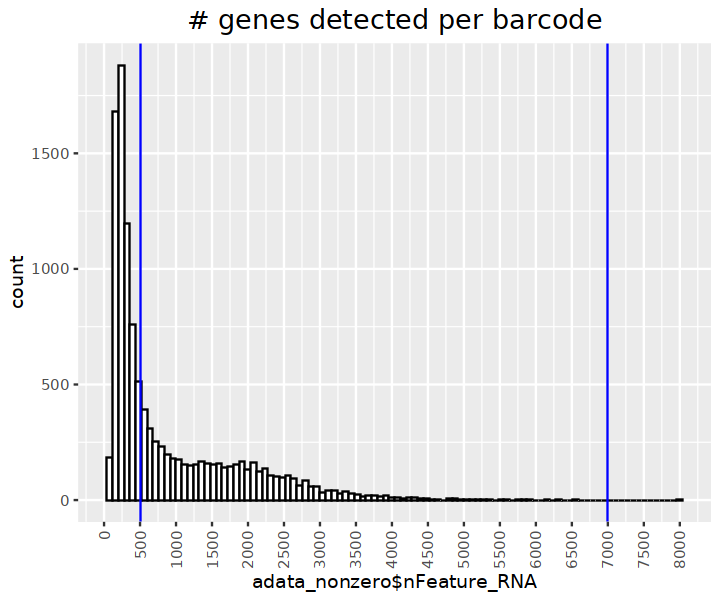

In [8]:
# Plot a histogram of the number of genes
nfeat_low <- 500
nfeat_hi <- 7000

table <- as.data.frame(colnames(adata_nonzero))
table <- cbind(table, adata_nonzero$nFeature_RNA)

options(repr.plot.width=6, repr.plot.height=5)
p<-ggplot(table, aes(x=adata_nonzero$nFeature_RNA)) + 
    geom_histogram(color="black", fill="white", bins=100) + 
    scale_x_continuous(breaks = scales::pretty_breaks(n = 25)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    geom_vline(xintercept=nfeat_low, color="blue") + geom_vline(xintercept=nfeat_hi, color="blue") +
    ggtitle("# genes detected per barcode") + theme(plot.title = element_text(hjust = 0.5, size=16))
p

In [9]:
# Subset based on your thresholds
adata_sub <- subset(
  x = adata_sub_amulet,
  subset = (nFeature_RNA >= nfeat_low & nFeature_RNA <= nfeat_hi)
)
print(paste(length(colnames(adata_sub[["RNA"]])),"total BCs after RNA threshold"))

[1] "4682 total BCs after RNA threshold"


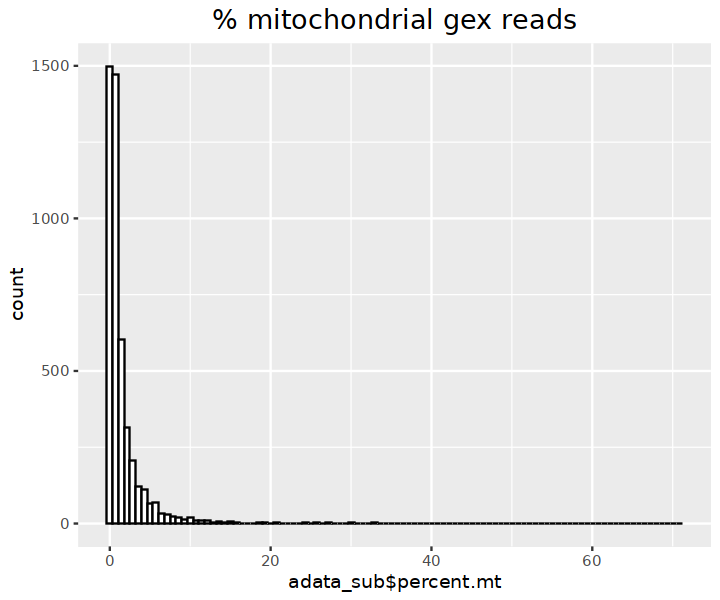

In [10]:
# Plot mitochondrial content histogram
table <- as.data.frame(colnames(adata_sub))
table <- cbind(table, adata_sub$percent.mt)

options(repr.plot.width=6, repr.plot.height=5)
p<-ggplot(table, aes(x=adata_sub$percent.mt)) + 
    geom_histogram(color="black", fill="white", bins=100) + 
    ggtitle("% mitochondrial gex reads") + theme(plot.title = element_text(hjust = 0.5, size=16))
p

### Add QC data from per_barcode_metrics.csv

In [11]:
# Load in and add metadata table
qc <- read.table(file.path(wd, 'outs', 'per_barcode_metrics.csv'), sep=',', header=TRUE, stringsAsFactors=1)
qc <- as.data.frame(qc)
rownames(qc) <- qc$gex_barcode
qc <- qc[Cells(adata_sub), 1:length(colnames(qc))]
adata_sub <- AddMetaData(adata_sub, qc)

### Filter Seurat Object using ATAC frag metric

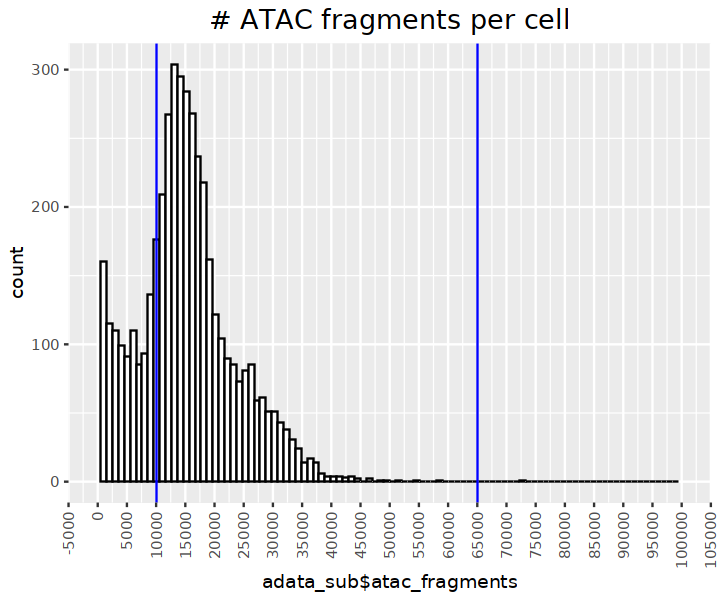

In [12]:
# Plot histogram of ATAC fragment counts
af_low <- 10000
af_hi <- 65000

table <- as.data.frame(colnames(adata_sub))
table <- cbind(table, adata_sub$atac_fragments)

options(repr.plot.width=6, repr.plot.height=5)
p<-ggplot(table, aes(x=adata_sub$atac_fragments)) + 
    geom_histogram(color="black", fill="white", bins=100) + 
    scale_x_continuous(limits=c(0,100000), breaks = scales::pretty_breaks(n = 25)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    geom_vline(xintercept=af_low, color="blue") + geom_vline(xintercept=af_hi, color="blue") +
    ggtitle("# ATAC fragments per cell") + theme(plot.title = element_text(hjust = 0.5, size=16))
p

In [13]:
# Actually subset
adata_sub_atac <- subset(
  x = adata_sub,
  subset = (atac_fragments >= af_low & atac_fragments<af_hi)
)
print(paste(length(colnames(adata_sub_atac[["RNA"]])),"total BCs after ATAC threshold"))

[1] "3435 total BCs after ATAC threshold"


### Remove multiplets

In [14]:
# Another multiple removal via CellRanger's multiplet calling
adata_sub_multiplet <- subset(
  x = adata_sub_atac,
  subset = excluded_reason != 1 
)
print(paste(length(colnames(adata_sub_multiplet[["RNA"]])),"total BCs after multiplet removal"))

[1] "3406 total BCs after multiplet removal"


### Add the fragment/ATAC data for the barcodes that have passed both of these filters and create a ChromatinAssay object (used to add ATAC data to a Seurat object)

In [15]:
# Set-up the atac fragment matrix along with annotations
atac_counts <- atac_counts[,colnames(adata_sub_multiplet)]
grange.counts <- StringToGRanges(rownames(atac_counts), sep = c(':', '-'))
grange.use <- seqnames(grange.counts) %in% standardChromosomes(grange.counts)
atac_counts <- atac_counts[as.vector(grange.use), ]
annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86)

In [16]:
# Create a chromassay from this
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- 'hg38'

frag.file <- file.path(wd, 'outs', 'atac_fragments.tsv.gz')
suppressWarnings(chrom_assay <- CreateChromatinAssay(counts=atac_counts, sep=c(':', '-'), genome='hg38', fragments=frag.file, min.cells=0, min.features=0, annotation=annotations))
adata_sub_multiplet[['ATAC']] <- chrom_assay
adata_sub_multiplet

Computing hash



An object of class Seurat 
133987 features across 3406 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: ATAC

### Compute TSS enrichment

In [17]:
# ATAC TSS enrichment
adata <- adata_sub_multiplet
DefaultAssay(adata) <- 'ATAC'
suppressMessages(adata <- TSSEnrichment(adata))
print(paste("ATAC median TSSe:", median(adata[[]][,'TSS.enrichment'])))

[1] "ATAC median TSSe: 4.37994928115093"


# Cluster Filtered Object

In [18]:
# RNA analysis
DefaultAssay(adata) <- 'RNA'
adata <- SCTransform(adata, verbose = FALSE) %>% RunPCA() %>% RunUMAP(dims=1:50, reduction.name='umap.rna', reduction.key='rnaUMAP_')

PC_ 1 
Positive:  AFF3, SNTG1, RBFOX1, RNF220, BRINP3, LRP1B, AC068587.4, HDAC9, RALYL, LSAMP 
	   SORCS1, ARHGAP24, CADM2, COL5A2, RAB3C, PLD5, TPH1, NLGN1, FAM155A, AC092691.1 
	   IL1RAPL1, MARCH1, GRIA4, RYR2, KCNJ3, LMX1A, GRIP1, STAC, NCKAP5, UNC5D 
Negative:  PDZD2, PTPRN2, INS, ERO1B, ST6GALNAC5, MT-CO1, MT-CO2, GSE1, MT-CO3, MT-ATP6 
	   MT-CYB, COL27A1, PCDH7, MLXIPL, AC011246.1, CHST9, SLC7A2, MYO3A, EDARADD, GLS 
	   SNED1, ZDHHC14, SDK1, GCG, MT-ND3, RAP1GAP2, LINC00511, MT-ND4, CNTN4, IQSEC1 
PC_ 2 
Positive:  CCSER1, PDE4D, PCDH7, ROBO2, ERO1B, CACNA2D1, GPC6, NRXN1, GLS, CNTN4 
	   NBEA, MAGI2, DACH1, CADPS, ST6GALNAC5, CDH18, LRRTM4, SPAG16, UNC5C, CHST9 
	   AQP4-AS1, AC112770.1, HS3ST5, SGCD, FOXP2, TRPM3, GALNT13, KCNMB2, LINC02315, SDK1 
Negative:  MT-CO2, MT-CO1, MT-CYB, MT-CO3, MT-ATP6, MT-ND3, MT-ND4, MT-ND2, RNF220, MT-ND5 
	   MT-ND1, CHGA, RBFOX1, CAMK1D, AC068587.4, CERS4, AFF3, ACAP3, SIPA1L3, ADARB2 
	   RTN4RL1, HNF1A-AS1, SHANK2, GSE1, PRDM16, RAP1GAP2, 

In [19]:
# ATAC analysis
DefaultAssay(adata) <- 'ATAC'
adata <- RunTFIDF(adata)
adata <- FindTopFeatures(adata, min.cutoff='q0')
adata <- RunSVD(adata)
adata <- RunUMAP(adata, reduction='lsi', dims=2:50, reduction.name='umap.atac', reduction.key='atacUMAP_')

Performing TF-IDF normalization



Running SVD

Scaling cell embeddings

14:32:19 UMAP embedding parameters a = 0.9922 b = 1.112

14:32:19 Read 3406 rows and found 49 numeric columns

14:32:19 Using Annoy for neighbor search, n_neighbors = 30

14:32:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:32:19 Writing NN index file to temp file /tmp/RtmpezJ6JT/file258cde63d330a3

14:32:19 Searching Annoy index using 1 thread, search_k = 3000

14:32:20 Annoy recall = 100%

14:32:21 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:32:23 Initializing from normalized Laplacian + noise (using irlba)

14:32:23 Commencing optimization for 500 epochs, with 124722 positive edges

14:32:28 Optimization finished



In [20]:
adata

An object of class Seurat 
155140 features across 3406 samples within 3 assays 
Active assay: ATAC (97386 features, 97386 variable features)
 2 other assays present: RNA, SCT
 4 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac

In [27]:
# Find integration anchors
adata <- FindMultiModalNeighbors(adata, reduction.list=list('pca', 'lsi'), dims.list=list(1:50, 2:50))

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.



Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph



In [28]:
# Run UMAP on integrated data
adata <- RunUMAP(adata, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')

11:10:09 UMAP embedding parameters a = 0.9922 b = 1.112



11:10:11 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

11:10:14 Initializing from normalized Laplacian + noise (using irlba)

11:10:14 Commencing optimization for 500 epochs, with 102712 positive edges

11:10:21 Optimization finished



In [29]:
# Clustering the weighted shared nearest neighbors graph
adata <- FindClusters(adata, graph.name='wsnn', algorithm=3, resolution = 0.5, verbose=FALSE)

In [30]:
# Add some metadata
adata$log_nCount_ATAC = log(adata$nCount_ATAC)
adata$log_nCount_SCT = log(adata$nCount_SCT)
adata$log_nFeature_ATAC = log(adata$nFeature_ATAC)
adata$log_nFeature_SCT = log(adata$nFeature_SCT)

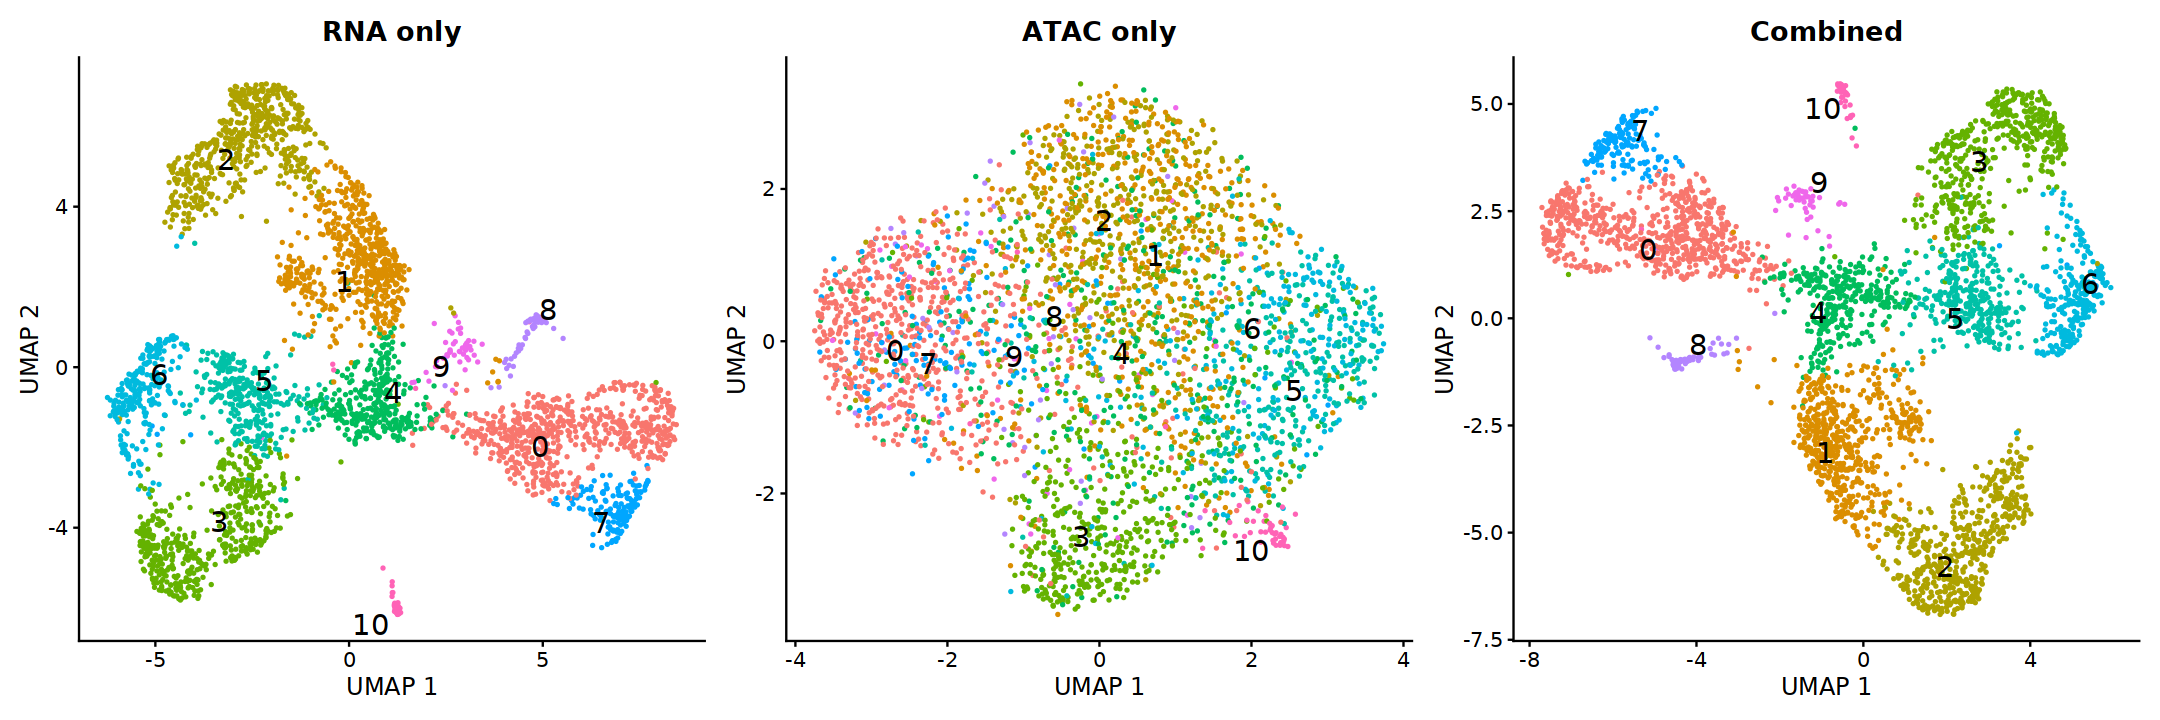

In [31]:
# Plot UMAPs
options(repr.plot.width=18, repr.plot.height=6)
p1 <- DimPlot(adata, reduction='umap.rna', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))

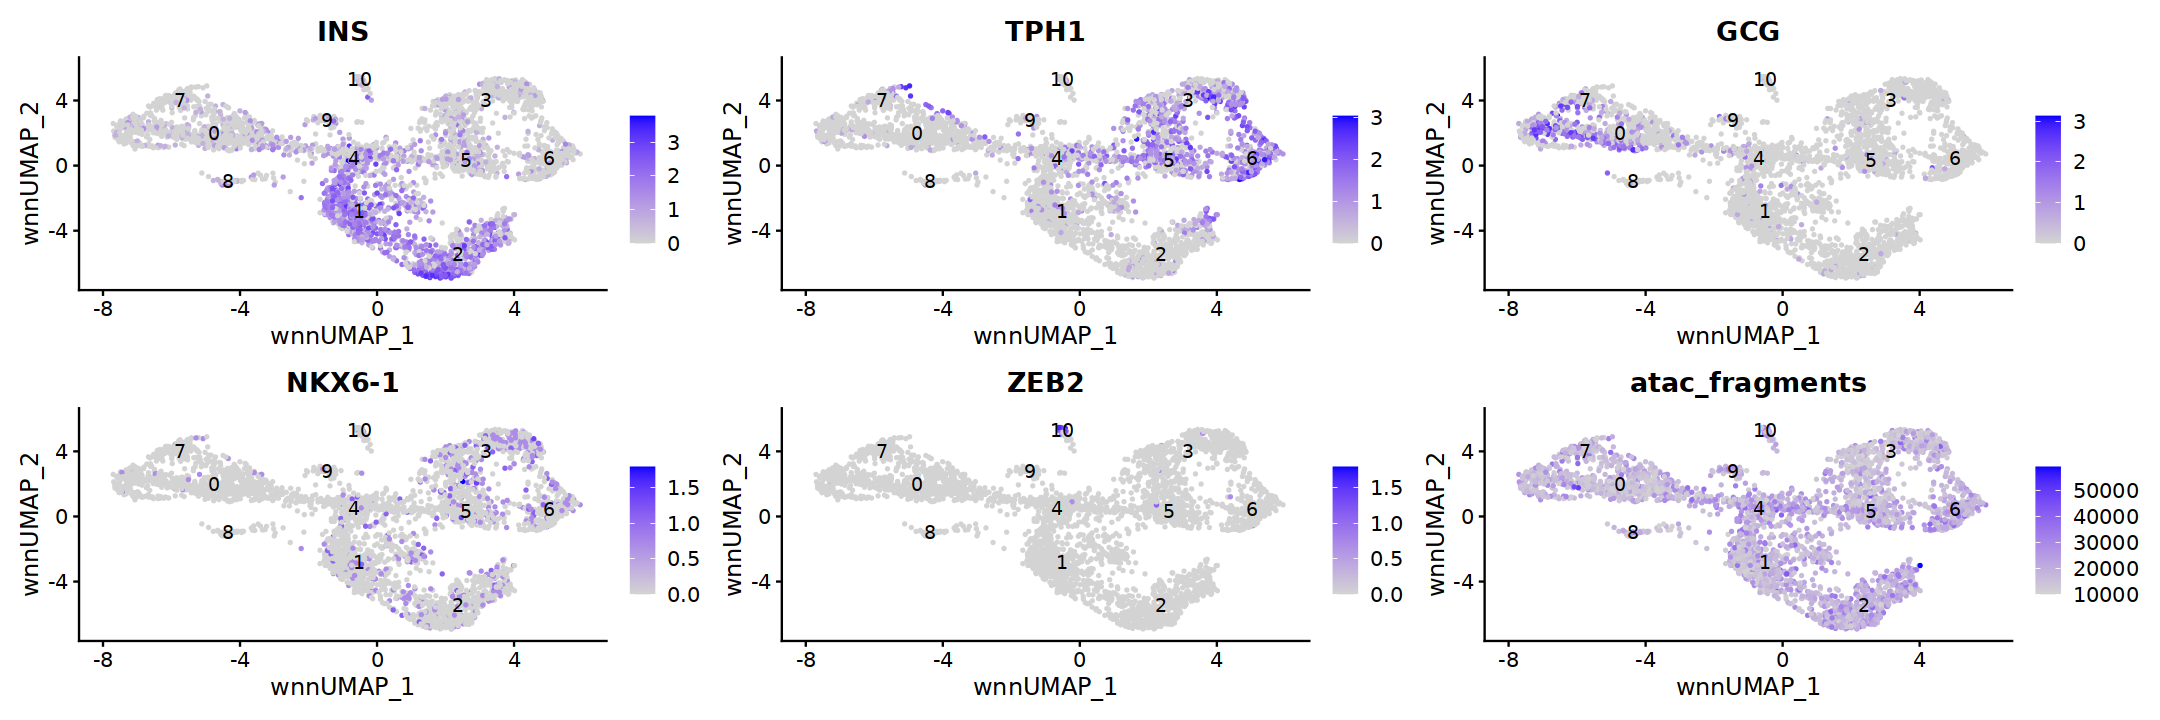

In [32]:
# Add some marker genes to the UMAP
DefaultAssay(adata) <- 'SCT'
FeaturePlot(adata, reduction='umap.wnn', features=c("INS", "TPH1", "GCG", "NKX6-1", "ZEB2", "atac_fragments"),
            ncol=3, label=TRUE)

## Run SoupX (currently using default settings)

In [33]:
# Load SoupX
suppressMessages(library(knitr))
opts_chunk$set(tidy=TRUE)
suppressMessages(library(SoupX))

In [34]:
# Load in the data for SoupX run
DefaultAssay(adata) <- 'RNA' 
toc = GetAssayData(object = adata, slot = "counts") 

# Read in raw RNA counts from CellRanger outputs
tod = Seurat::Read10X_h5(file.path(wd, 'outs', 'raw_feature_bc_matrix.h5'))$`Gene Expression`

# Put in UMAP embedding and cluster data 
metadata <- (cbind(as.data.frame(adata[["umap.wnn"]]@cell.embeddings),
                   as.data.frame(Idents(adata)), 
                   as.data.frame(Idents(adata)))) 
colnames(metadata) <- c("RD1","RD2","Cluster","Annotation")

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [40]:
rownames(toc[1:10, 1:10])

[1] "MIR1302-2HG" "FAM138A"     "OR4F5"       "AL627309.1"  "AL627309.3" 
 [6] "AL627309.2"  "AL627309.5"  "AL627309.4"  "AP006222.2"  "AL732372.1"

In [42]:
rownames(tod[1:10, 1:10])

[1] "MIR1302-2HG" "FAM138A"     "OR4F5"       "AL627309.1"  "AL627309.3" 
 [6] "AL627309.2"  "AL627309.5"  "AL627309.4"  "AP006222.2"  "AL732372.1"

In [47]:
# Read in gene list
soupx.markers.fp <- '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/14Sep22/seurat/sc_islet_genelist.txt'
soupx.markers <- read.table(soupx.markers.fp, sep='\t', header=TRUE)
Genes1 <- c(soupx.markers$Gene[[1]])
Genes2 <- c(soupx.markers$Gene[[2]])
Genes3 <- c(soupx.markers$Gene[[3]])
Genes4 <- c(soupx.markers$Gene[[4]])
Genes4

[1] "TPH1"

In [48]:
# Create soup channel
sc = SoupChannel(tod,toc)
sc = setDR(sc,metadata[colnames(sc$toc),c("RD1", "RD2")])
sc = setClusters(sc,setNames(metadata$Cluster,rownames(metadata)))

In [52]:
names(sc)

[1] "toc"         "metaData"    "nDropUMIs"   "soupProfile" "DR"

In [53]:
head(sc$metaData)

[1] "RD1" "RD2"

In [55]:
# Run SoupX!
useToEst = estimateNonExpressingCells(
    sc,
    nonExpressedGeneList = list(A=Genes1, B=Genes2, C=Genes3, D=Genes4),)
sc = calculateContaminationFraction(sc,
                                    list(A=Genes1, B=Genes2, C=Genes3, D=Genes4),
                                    useToEst=useToEst)

print(paste('Estimated global contamination fraction:',100*exp(coef(sc$fit))[[1]],"%"))

Estimated global contamination fraction of 8.83%



[1] "Estimated global contamination fraction: 8.82706123057272 %"


In [56]:
# Run SoupX!
out = adjustCounts(sc)
adata2 = CreateSeuratObject(out)

Expanding counts from 11 clusters to 3406 cells.



In [64]:
cntSoggy = rowSums(sc$toc > 0)
cntStrained = rowSums(out > 0)
num_zeroed_cells = cntSoggy - cntStrained
tail(sort(num_zeroed_cells))

MT-ATP6  MT-CO3  MT-CYB  MT-CO1     INS  MT-CO2 
    212     260     297     315     423     461

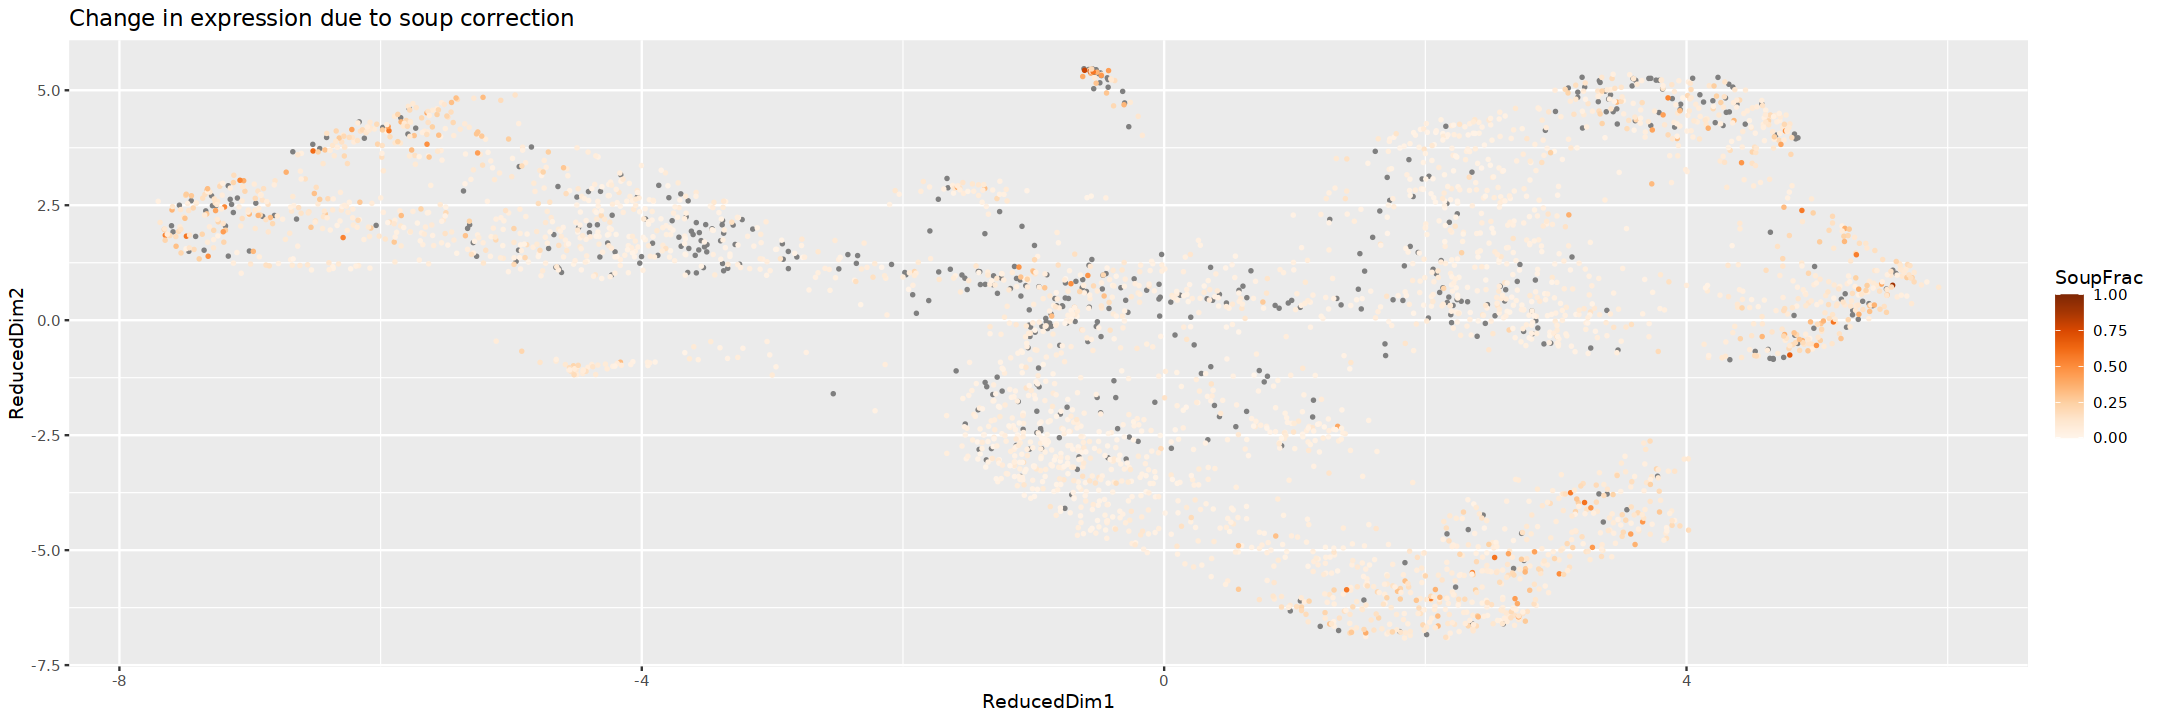

In [63]:
plotChangeMap(sc, out, "CMIP")

# Re-cluster with soup removed

In [54]:
# Get the mitcochondrial content
adata2[['percent.mt']] <- PercentageFeatureSet(adata2, pattern = '^MT-')

In [55]:
# Add in previous raw RNA data as another assay
DefaultAssay(adata) <- 'RNA'
raw_rna <-  GetAssayData(object = adata, slot = "counts")

raw_rna_assay <- CreateAssayObject(counts = raw_rna)
adata2[['RNA_raw']] <- raw_rna_assay

In [56]:
# Create another chromatin assay
frag.file <- file.path(wd, 'outs', 'atac_fragments.tsv.gz')
suppressWarnings(chrom_assay <- CreateChromatinAssay(counts=atac_counts, sep=c(':', '-'), genome='hg38', fragments=frag.file, min.cells=0, min.features=0, annotation=annotations))
adata2[['ATAC']] <- chrom_assay

Computing hash



In [57]:
# RNA analysis
DefaultAssay(adata2) <- 'RNA'
adata2 <- SCTransform(adata2, verbose = FALSE) %>% RunPCA() %>% RunUMAP(dims=1:50, reduction.name='umap.rna', reduction.key='rnaUMAP_')

# ATAC analysis
DefaultAssay(adata2) <- 'ATAC'
adata2 <- RunTFIDF(adata2)
adata2 <- FindTopFeatures(adata2, min.cutoff='q0')
adata2 <- RunSVD(adata2)
adata2 <- RunUMAP(adata2, reduction='lsi', dims=2:50, reduction.name='umap.atac', reduction.key='atacUMAP_')

# Integrative analysis
adata2 <- FindMultiModalNeighbors(adata2, reduction.list=list('pca', 'lsi'), dims.list=list(1:50, 2:50))
adata2 <- RunUMAP(adata2, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')
adata2 <- FindClusters(adata2, graph.name='wsnn', algorithm=3, resolution = .2, verbose=FALSE)

# Add some metadata
adata2$log_nCount_ATAC = log(adata2$nCount_ATAC)
adata2$log_nCount_SCT = log(adata2$nCount_SCT)
adata2$log_nFeature_ATAC = log(adata2$nFeature_ATAC)
adata2$log_nFeature_SCT = log(adata2$nFeature_SCT)

PC_ 1 
Positive:  AFF3, SNTG1, RBFOX1, RNF220, BRINP3, LRP1B, AC068587.4, RALYL, HDAC9, LSAMP 
	   SORCS1, ARHGAP24, COL5A2, CADM2, RAB3C, PLD5, NLGN1, TPH1, FAM155A, IL1RAPL1 
	   AC092691.1, GRIA4, MARCH1, KCNJ3, RYR2, GRIP1, UNC5D, STAC, LMX1A, ANKS1B 
Negative:  MT-CO2, MT-CO1, PDZD2, PTPRN2, MT-CO3, INS, MT-CYB, MT-ATP6, ERO1B, GSE1 
	   MT-ND3, MT-ND4, MLXIPL, MT-ND2, RAP1GAP2, ST6GALNAC5, SIPA1L3, COL27A1, MT-ND5, IQSEC1 
	   FBXO17, EDARADD, LINC00511, MT-ND1, SNED1, CACNA1A, ZDHHC14, AC011246.1, SLC7A2, ACAP3 
PC_ 2 
Positive:  CCSER1, PDE4D, PCDH7, ROBO2, ERO1B, GLS, CACNA2D1, CNTN4, ST6GALNAC5, NRXN1 
	   GPC6, MAGI2, NBEA, CADPS, UNC5C, CHST9, CDH18, LRRTM4, AC112770.1, SDK1 
	   HS3ST5, DACH1, AQP4-AS1, TRPM3, KCNMB2, PRKD1, EYS, SPAG16, ASPH, SLC4A10 
Negative:  MT-CO2, MT-CO1, MT-CYB, MT-CO3, MT-ATP6, RNF220, MT-ND3, MT-ND4, MT-ND2, RBFOX1 
	   MT-ND5, MT-ND1, CAMK1D, AFF3, AC068587.4, CHGA, SNTG1, CERS4, ADARB2, SIPA1L3 
	   SORCS1, ACAP3, SHANK2, RAP1GAP2, TPH1, RTN4RL

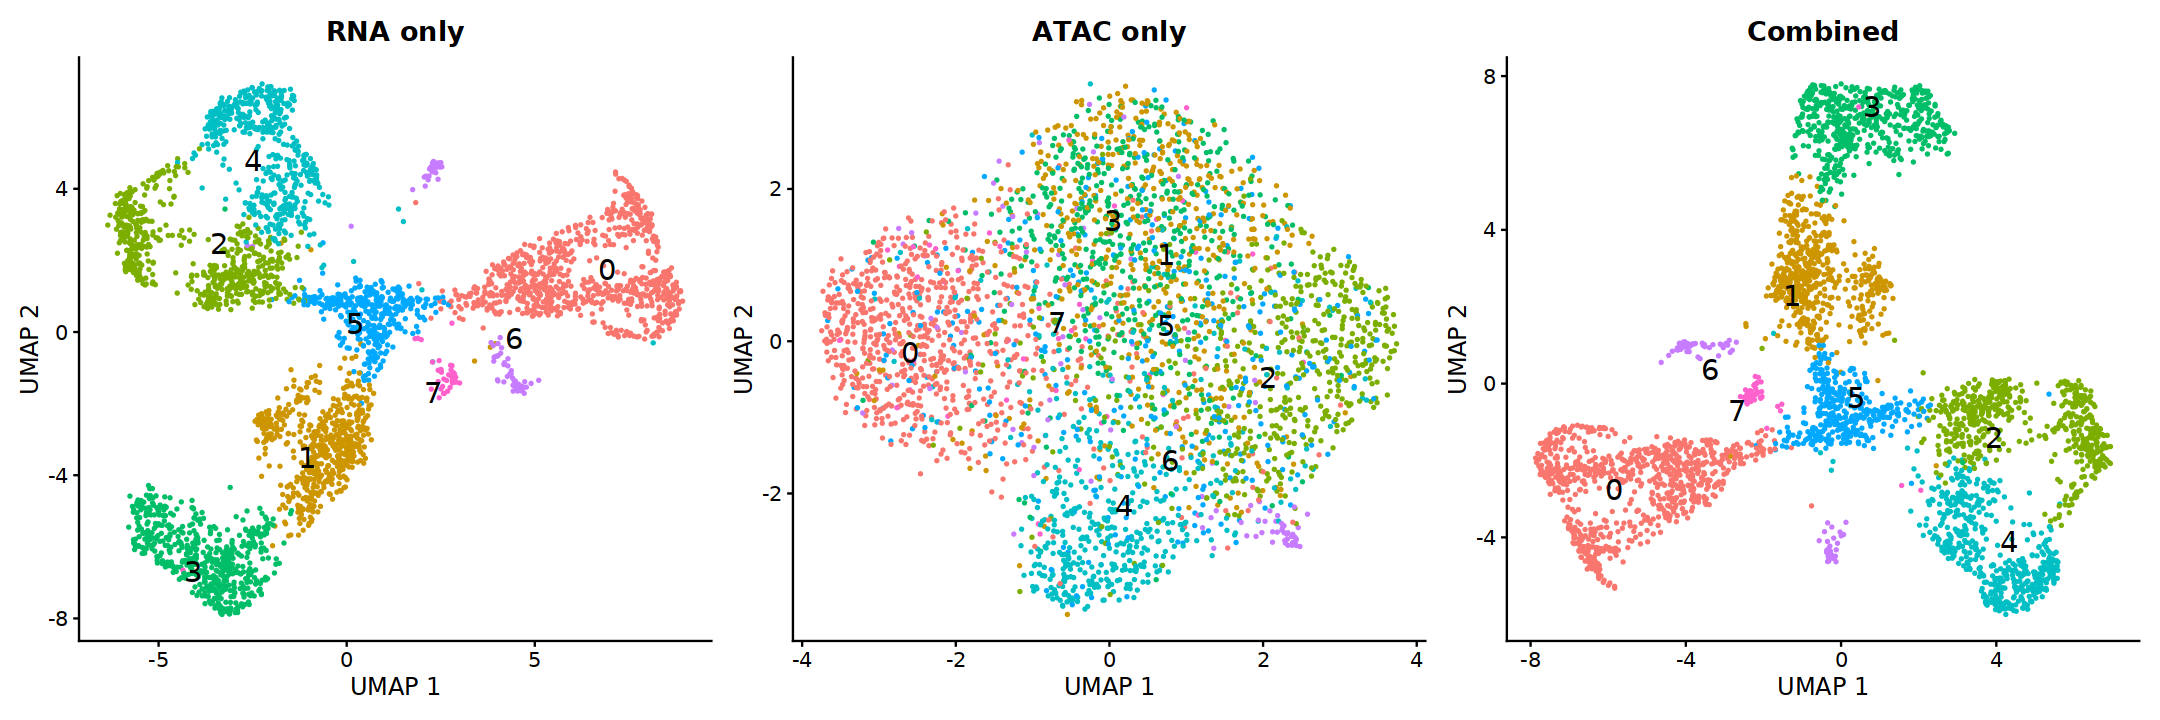

In [58]:
# Plot with soup removed
options(repr.plot.width=18, repr.plot.height=6)
p1 <- DimPlot(adata2, reduction='umap.rna', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata2, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata2, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))

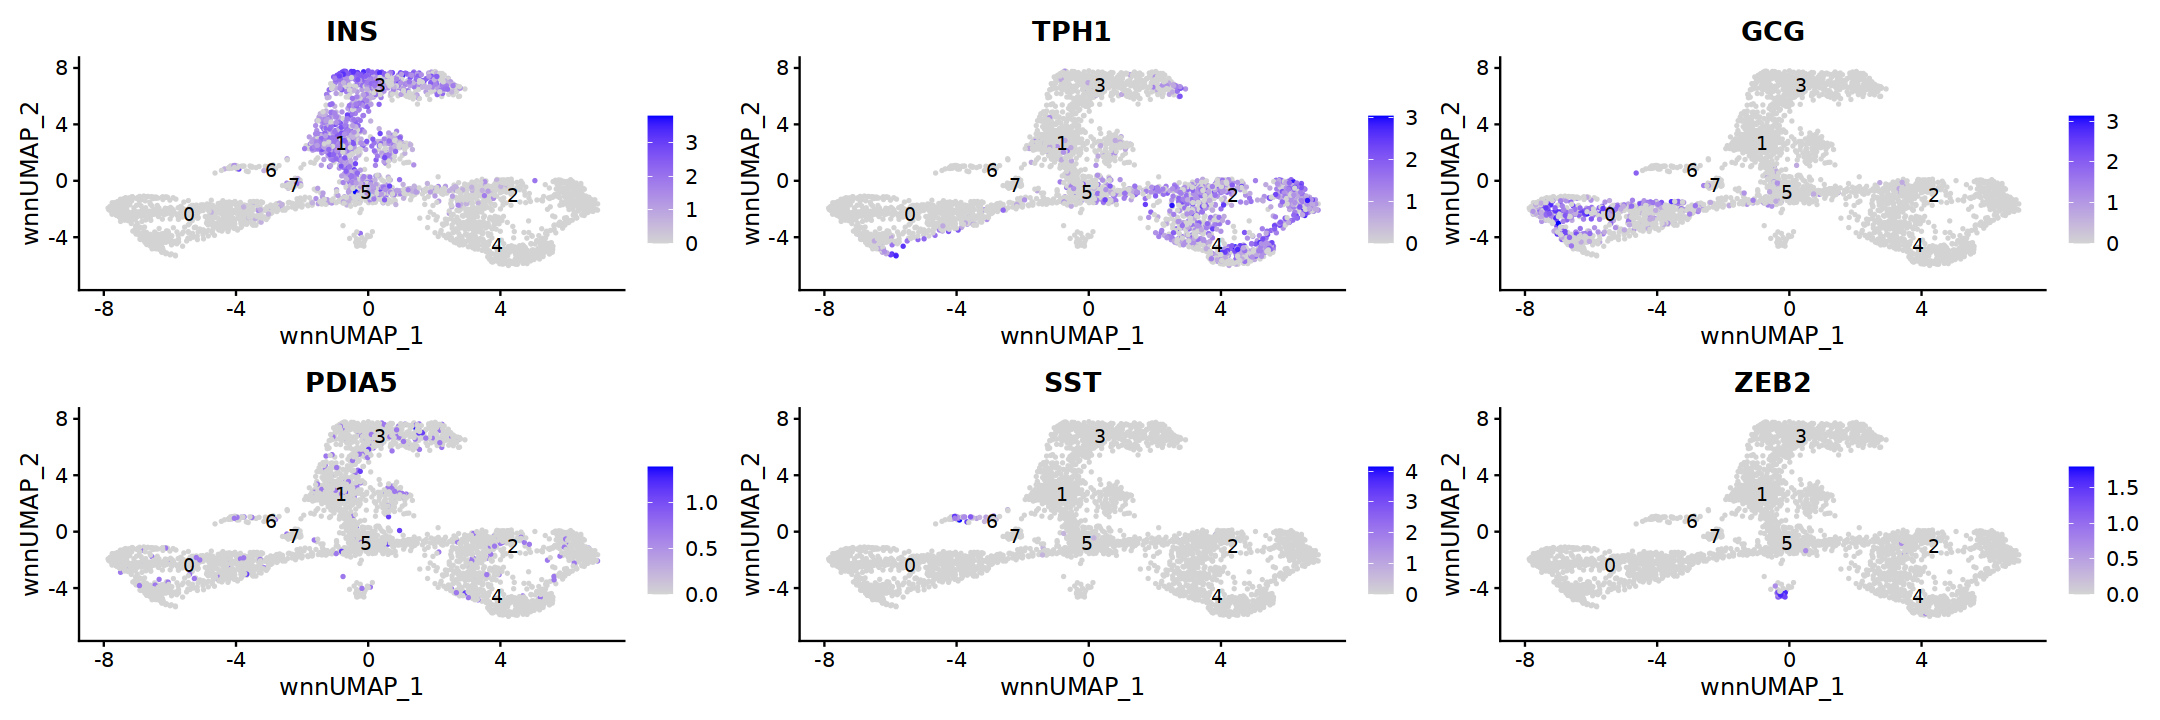

In [59]:
# Plot with Soup removed
DefaultAssay(adata2) <- 'SCT'
FeaturePlot(adata2, reduction='umap.wnn', features=c("INS", "TPH1", "GCG", "PDIA5", "SST", "ZEB2", "atac_fragments"),
            ncol=3, label=TRUE)

In [ ]:
# Save this obect
saveRDS(adata2, file="/cellar/users/aklie/data/igvf/igvf_sc-islet_10X-Multiome/annotation/14Sep23/igvf_dm32a.qc.rds")

# DONE!

---